# Análisis de Series de Tiempo: IBM vs. Walmart

El **análisis de series de tiempo** es una herramienta poderosa en el mundo de las finanzas y el mercado de valores. Nos permite descomponer los datos históricos de los precios de las acciones para identificar patrones, tendencias y ciclos, lo cual es fundamental para la toma de decisiones informada. En este estudio, examinamos el desempeño de las acciones de dos gigantes corporativos: **IBM** y **Walmart**, a lo largo de los últimos cinco años (2019-2024). A través de un análisis exhaustivo, que incluye correlación de rendimientos, descomposición de series, pruebas de estacionariedad, autocorrelación y pronósticos con medias móviles, buscamos entender el comportamiento de estas acciones y su potencial para la diversificación de una cartera de inversión.


In [16]:
# Primero importamos las librerias que usaremos a lo largo del desrrollo
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [17]:
#Descargamos los datos para los ultimos 5 años
print("Descargando datos históricos...") 
tickers = ['IBM', 'WMT']
start_date = '2019-08-23'
end_date = '2024-08-23'

# Extraemos solo fecha y los precios de cierre e imprimimos el total de nuestros registros
data = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Close']
ibm = data['IBM']
walmart = data['WMT']
print(f"IBM: {len(ibm)} registros | Walmart: {len(walmart)} registros")


Descargando datos históricos...


[*********************100%***********************]  2 of 2 completed

IBM: 1258 registros | Walmart: 1258 registros


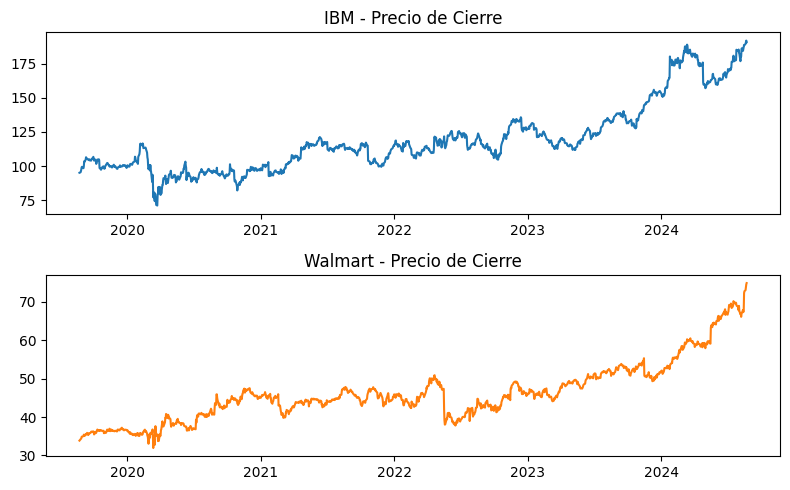

In [18]:
# Generamos una Visualización inicial
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
axes[0].plot(ibm.index, ibm.values, color='#1f77b4')
axes[0].set_title('IBM - Precio de Cierre')
axes[1].plot(walmart.index, walmart.values, color='#ff7f0e')
axes[1].set_title('Walmart - Precio de Cierre')
plt.tight_layout()
plt.show()

In [19]:
# Evaluamos la correlación entre rendimientos y la llamamos
returns_ibm = ibm.pct_change().dropna()
returns_walmart = walmart.pct_change().dropna()
correlation = returns_ibm.corr(returns_walmart)
print(f"\n Correlación de rendimientos: {correlation:.4f}")



 Correlación de rendimientos: 0.3008


El valor de **0.3008** sugiere que cuando una de estas acciones sube, la otra también tiende a subir, pero no de manera consistente o predecible. Esto es una buena noticia para la diversificación. La diversificación consiste en combinar activos que tienen una correlación baja o negativa para reducir el riesgo general de la cartera.

**Nota:** Si los rendimientos de IBM y Walmart estuvieran fuertemente correlacionados (cerca de 1), un evento negativo que afectara a una de las empresas probablemente afectaría a la otra de manera similar, aumentando el riesgo, sin embargo, con una correlación débil, las ganancias de un activo podrían compensar las pérdidas del otro, protegiendo así la cartera de la volatilidad extrema.

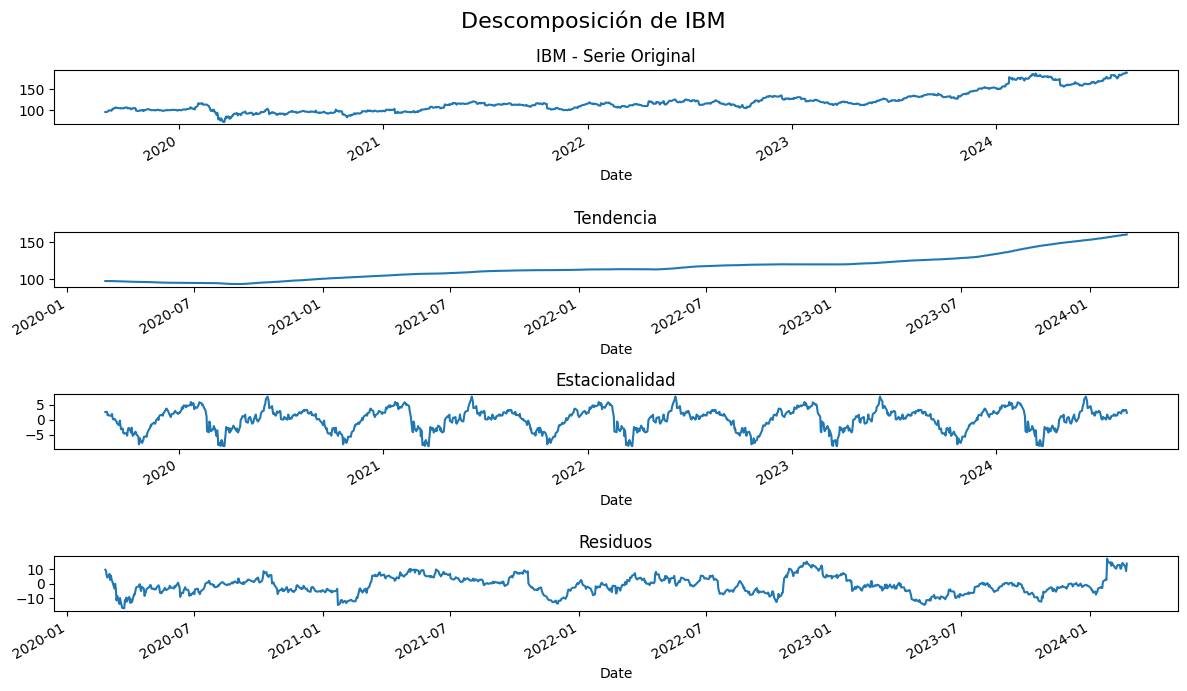

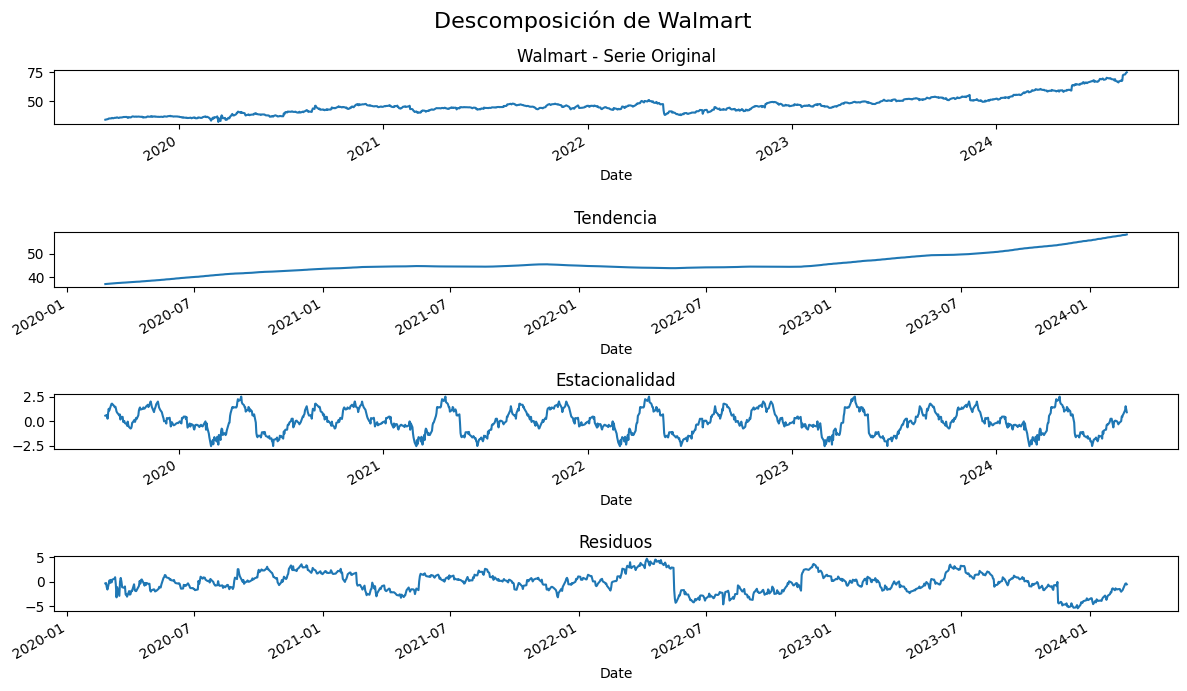

In [35]:
# Hacemos la Descomposición de series
period = 252
for name, series in [('IBM', ibm), ('Walmart', walmart)]:
    fig, axes = plt.subplots(4, 1, figsize=(12, 7))
    decomp = seasonal_decompose(series.dropna(), model='additive', period=period)
    decomp.observed.plot(ax=axes[0], title=f'{name} - Serie Original')
    decomp.trend.plot(ax=axes[1], title='Tendencia')
    decomp.seasonal.plot(ax=axes[2], title='Estacionalidad')
    decomp.resid.plot(ax=axes[3], title='Residuos')
    plt.suptitle(f'Descomposición de {name}', fontsize=16)
    plt.tight_layout()
    plt.show()

## Acciones de IBM serie original y descomposición de la serie temporal (tendencia, estacionalidad y residuos)

La descomposición de la serie de tiempo de IBM demuestra que su precio ha tenido una trayectoria ascendente y robusta, impulsada por una fuerte tendencia de crecimiento. Aunque existen patrones estacionales y variaciones aleatorias, la dirección general es positiva, lo que sugiere una solidez y estabilidad en el mercado de las acciones de la compañía

## Acciones de Walmart serie original y descomposición de la serie temporal (tendencia, estacionalidad y residuos)
El análisis de la descomposición de la serie de tiempo de Walmart revela una trayectoria ascendente y robusta, impulsada por una fuerte tendencia de crecimiento. A pesar de las fluctuaciones cíclicas y el ruido aleatorio, la dirección general es positiva, lo que indica solidez y estabilidad en el mercado

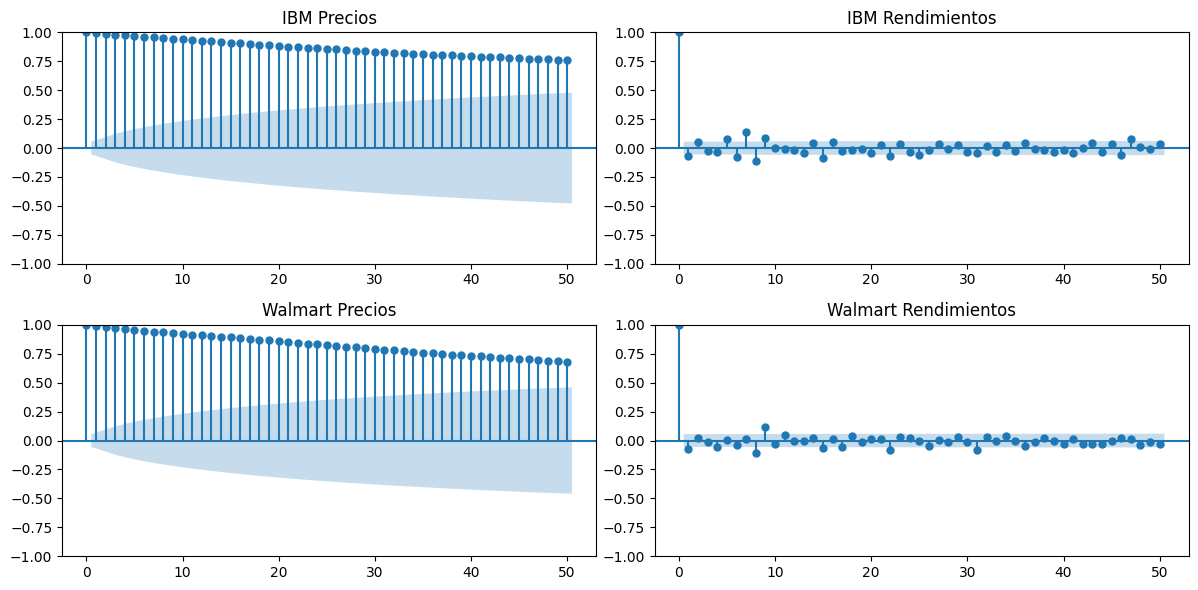

In [39]:
# Ahora evaluamos la Autocorrelación
max_lags = 50
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plot_acf(ibm.dropna(), lags=max_lags, ax=axes[0, 0])
axes[0, 0].set_title('IBM Precios')
plot_acf(returns_ibm.dropna(), lags=max_lags, ax=axes[0, 1])
axes[0, 1].set_title('IBM Rendimientos')
plot_acf(walmart.dropna(), lags=max_lags, ax=axes[1, 0])
axes[1, 0].set_title('Walmart Precios')
plot_acf(returns_walmart.dropna(), lags=max_lags, ax=axes[1, 1])
axes[1, 1].set_title('Walmart Rendimientos')
plt.tight_layout()
plt.show()

En las gráficas de rendimientos de ambas empresas, los valores de autocorrelación son prácticamente cero para todos los "lags" (desfases temporales). Esto significa que no hay una correlación significativa entre los rendimientos de un día y los de los días anteriores, lo que se traduce en un **Mercado eficiente** ya que la falta de autocorrelación en los rendimientos es una de las características de este y esto sugiere que toda la información relevante ya está reflejada en el precio actual de las acciones, por lo que los movimientos futuros son en gran medida aleatorios e impredecibles, siguiendo la teoría del camino aleatorio.

A diferencia de los rendimientos, las gráficas de la izquierda (Autocorrelación de Precios) muestran una correlación muy alta que disminuye lentamente con el tiempo, esto es considerado un comportamiento normal, ya que el precio de hoy está intrínsecamente relacionado con el precio de ayer, sin embargo, esta correlación no tiene un valor predictivo para los rendimientos futuros.

In [40]:
# Hacemos la Prueba de Dickey-Fuller
def interpretar_dickey_fuller(p_value):
    return "Estacionaria" if p_value < 0.05 else "No estacionaria"

for name, series in [('IBM Precios', ibm), ('Walmart Precios', walmart),
                     ('IBM Rendimientos', returns_ibm), ('Walmart Rendimientos', returns_walmart)]:
    p = adfuller(series.dropna())[1]
    print(f"{name}: {interpretar_dickey_fuller(p)} (p-value: {p:.6f})")


IBM Precios: No estacionaria (p-value: 0.960051)
Walmart Precios: No estacionaria (p-value: 0.986775)
IBM Rendimientos: Estacionaria (p-value: 0.000000)
Walmart Rendimientos: Estacionaria (p-value: 0.000000)


**NOTA:** Con esta pueba de Dickey-Fuller pretendemos evalúar si una serie de tiempo es estacionaria o no, aclarando que una serie estacionaria es aquella cuyas propiedades estadísticas, como la media y la varianza, se mantienen constantes a lo largo del tiempo.

- **Precios de IBM y Walmart:** Ambas series de precios resultan ***"No estacionarias"*** con valores de p-value muy altos (cercanos a 1.0), esto confirma que el precio de las acciones tiene una tendencia a largo plazo y no fluctúa alrededor de una media constante, los precios de hoy están fuertemente influenciados por los precios de ayer, lo que es una característica de las series no estacionarias.

- **Rendimientos de IBM y Walmart:** Ambas series de rendimientos resultan ***"Estacionarias"*** con valores de p-value cercanos a 0.0. Un p-value menor a 0.05 es el umbral para considerar una serie estacionaria, lo cual  significa que los rendimientos fluctúan alrededor de una media constante (en este caso, cercana a cero) y son predecibles en términos de sus propiedades estadísticas a lo largo del tiempo.

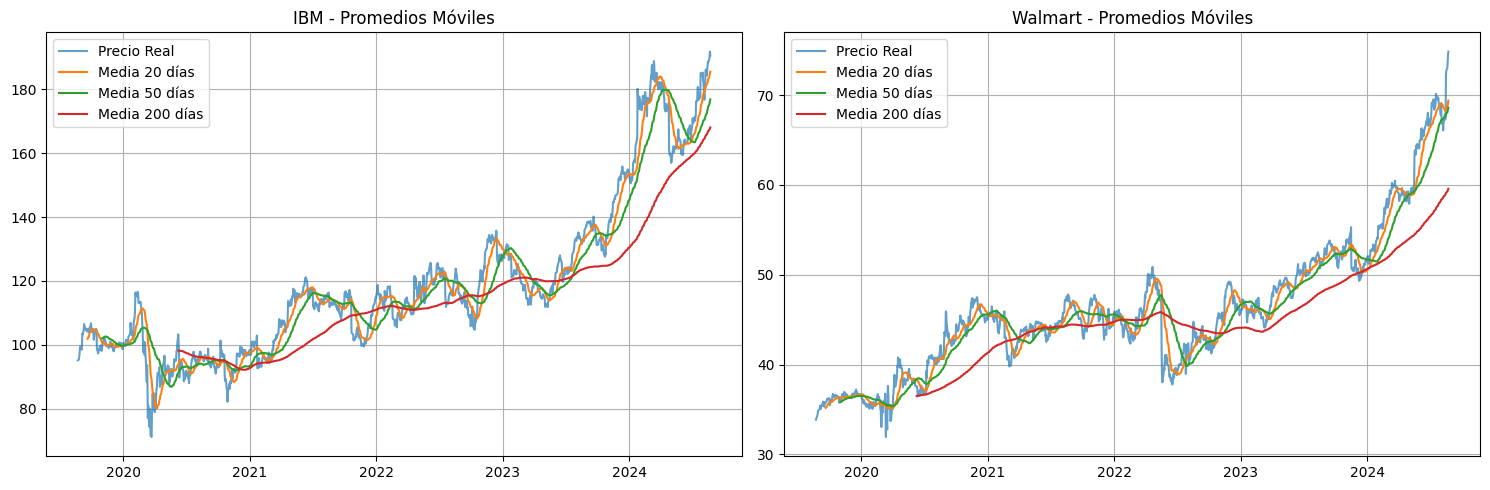

In [41]:
# Cálculamos los Promedios móviles
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, series, name in zip(axes, [ibm, walmart], ['IBM', 'Walmart']):
    ax.plot(series.index, series, label='Precio Real', alpha=0.7)
    for win in [20, 50, 200]:
        ax.plot(series.rolling(win).mean(), label=f'Media {win} días')
    ax.set_title(f'{name} - Promedios Móviles')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

**Nota:** Con los **promedios móviles** pretendemos visualizar los indicadores técnicos que suavizan las fluctuaciones de los precios para identificar la tendencia subyacente de un activo. En las gráficas de IBM y Walmart, se calculan las medias de los precios de cierre de 20, 50 y 200 días.

Estos promedios móviles nos permiten ver la dirección real del mercado sin el "ruido" de las fluctuaciones diariasy podemos ver que las gráficas mos muestran que a pesar de la volatilidad a corto plazo, las acciones de IBM y Walmart han tenido un desempeño muy fuerte y una sólida tendencia alcista a lo largo del tiempo.

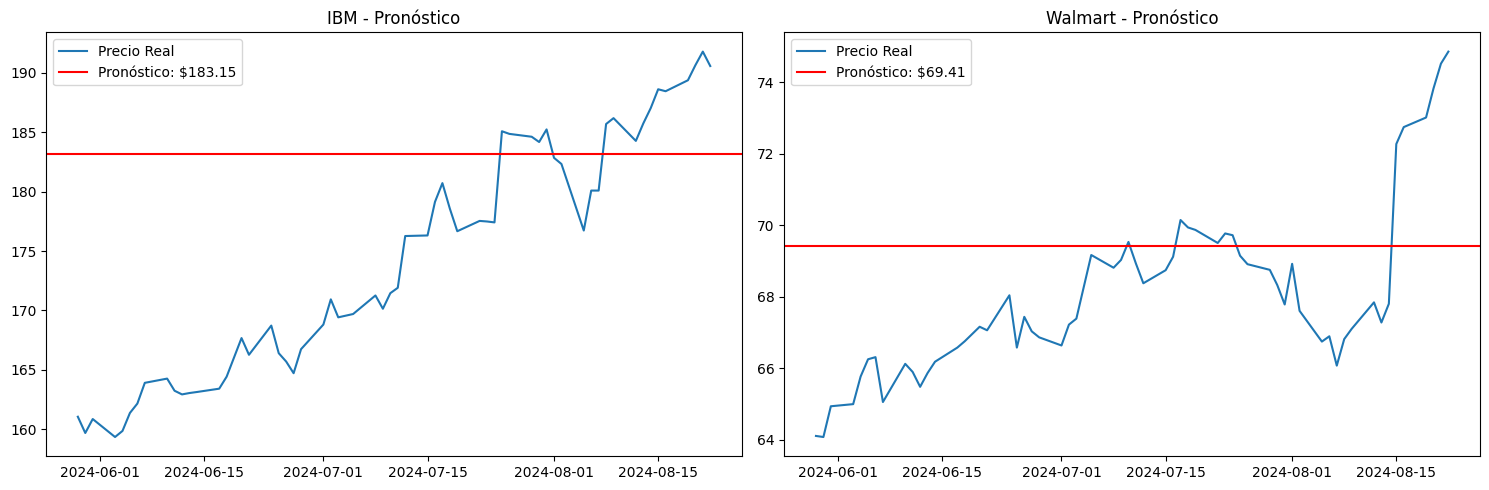

Pronóstico para el siguiente día - IBM: 190.57569885253906
Pronóstico para el siguiente día - Walmart: 74.85018157958984


In [45]:
# Hacemos el  Pronóstico día siguiente y lo gráficamos
def predecir_siguiente_dia(series, window=30):
    return series.tail(window).mean()

pred_ibm = predecir_siguiente_dia(ibm)
pred_walmart = predecir_siguiente_dia(walmart)
last_ibm = ibm.iloc[-1]
last_walmart = walmart.iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, series, pred, name, last in zip(axes, [ibm, walmart], [pred_ibm, pred_walmart],
                                        ['IBM', 'Walmart'], [last_ibm, last_walmart]):
    recent = series.tail(60)
    ax.plot(recent, label='Precio Real')
    ax.axhline(y=pred, color='red', label=f'Pronóstico: ${pred:.2f}')
    ax.set_title(f'{name} - Pronóstico')
    ax.legend()
plt.tight_layout()
plt.show()

# Impresión númerioca del Pronóstico para el siguiente día
print(f"Pronóstico para el siguiente día - IBM: {last_ibm}")
print(f"Pronóstico para el siguiente día - Walmart: {last_walmart}")

Ambos pronósticos **(IBM: $190.57, Walmart: $74.85)** son un punto de referencia basado en los datos históricos. Es importante notar que el precio real reciente ha superado a estos pronósticos en ambos casos. Esto podría significar que el modelo, aunque útil, no ha ajustado su predicción a la aceleración del crecimiento que se ha observado en el último periodo. 

In [46]:
# Evaluaremos nuestra precisión
def evaluar_precision(series, test_size=30, window=30):
    series = series.dropna()
    if len(series) < test_size + window:
        return None
    test = series.tail(test_size)
    predictions = []
    for i in range(test_size):
        pred = series.iloc[-(test_size + window - i):-(test_size - i)].tail(window).mean()
        predictions.append(pred)
    actuals = test.values
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mape = np.mean(np.abs((actuals - np.array(predictions)) / actuals)) * 100
    return rmse, mape

eval_ibm = evaluar_precision(ibm)
eval_walmart = evaluar_precision(walmart)

print("\n Evaluación de Precisión:")
print("=" * 50)
print(f"IBM RMSE: ${eval_ibm[0]:.2f}, MAPE: {eval_ibm[1]:.2f}%")
print(f"Walmart RMSE: ${eval_walmart[0]:.2f}, MAPE: {eval_walmart[1]:.2f}%")


 Evaluación de Precisión:
IBM RMSE: $9.70, MAPE: 5.06%
Walmart RMSE: $2.58, MAPE: 2.98%


La evaluación de precisión nos indica que el modelo de pronóstico de Walmart es considerablemente más preciso que el de IBM. Aunque ambos modelos tienen cierto grado de error, la diferencia en los valores de RMSE y MAPE sugiere que el modelo de Walmart es más confiable para predecir los movimientos de precios de esa acción en particular

In [48]:
# Por ultimo sacaremos un Reporte final
reporte = f"""
REPORTE FINAL - IBM vs WALMART
=================================
• Correlación de rendimientos: {correlation:.4f}
• IBM pronóstico: ${pred_ibm:.2f} vs último: ${last_ibm:.2f}
• Walmart pronóstico: ${pred_walmart:.2f} vs último: ${last_walmart:.2f}
• IBM MAPE: {eval_ibm[1]:.2f}%
• Walmart MAPE: {eval_walmart[1]:.2f}%
=================================
"""
print(reporte)


REPORTE FINAL - IBM vs WALMART
• Correlación de rendimientos: 0.3008
• IBM pronóstico: $183.15 vs último: $190.58
• Walmart pronóstico: $69.41 vs último: $74.85
• IBM MAPE: 5.06%
• Walmart MAPE: 2.98%



## Conclusión
El análisis detallado de las series de tiempo para las acciones de IBM y Walmart revela información clave sobre su comportamiento y su relación. En primer lugar, la correlación de rendimientos entre ambas empresas es débil, con un valor de **0.3008**. Esto es una excelente noticia para la **diversificación de carteras**, ya que un evento negativo que afecte a una de las empresas probablemente no impactará a la otra de la misma manera, lo que ayuda a mitigar el riesgo de inversión.

Ambas series de precios mostraron una fuerte **tendencia ascendente** y robusta durante el periodo de estudio, a pesar de las fluctuaciones estacionales y el ruido inherente al mercado. Las pruebas de Dickey-Fuller confirmaron que las series de precios son **no estacionarias**, lo cual es un comportamiento típico, mientras que los rendimientos son **estacionarios**, fluctuando alrededor de una media constante. Este hallazgo es coherente con la teoría del camino aleatorio y la eficiencia del mercado, donde los rendimientos no tienen una autocorrelación significativa y los movimientos futuros son en gran medida impredecibles.

Los pronósticos basados en medias móviles, aunque útiles como punto de referencia, subestimaron el crecimiento reciente de ambas acciones, lo que sugiere una aceleración alcista en el mercado no capturada completamente por el modelo. En términos de precisión, el modelo de pronóstico para **Walmart** resultó ser más confiable, con un error porcentual absoluto medio (MAPE) de **2.98%**, en comparación con el **5.06%** de IBM.

En resumen, este análisis demostró que tanto IBM como Walmart son activos con un sólido desempeño y una tendencia positiva. Sin embargo, la baja correlación entre ellas las convierte en candidatas ideales para combinar en una cartera diversificada. El estudio no solo resalta la utilidad de las herramientas de análisis de series de tiempo en la evaluación de activos financieros, sino que también subraya la importancia de considerar múltiples indicadores para obtener una visión completa y robusta de la salud de una inversión.